# CNN 연습
## 1. Load datasets

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn  # NN
import torch.nn.functional as F
import torch.optim as optim

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
### train set ###
#    : CIFAR 10 dataset (6만개 이미지 데이터셋)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=2)
### test set ###
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

# 이미지 분류 결과: 10개 사물
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
def imshow(img):
  img = img/2 + 0.5  #unnormalize
  np_img = img.numpy()   # 이미지를 숫자로 변환(넘파이)
  print(np.transpose(np_img, (1,2,0)).shape)  #숫자 출력
  plt.imshow(np.transpose(np_img, (1,2,0)))   #이미지 출력

  plt.show()

#### training img를 출력해보자


In [4]:
print(trainloader)

(36, 274, 3)


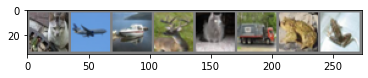

In [5]:
data_iter = iter(trainloader)  #random 하게 해주는 효과
images, labels = data_iter.next()

# 이미지 출력
imshow(torchvision.utils.make_grid(images))

In [6]:
# label로 출력 (숫자)
print(' '.join('%s' % classes[labels[j]] for j in range(8)))

# 이미지 하나의 size 알아보기
print(images[1].shape)

cat plane ship deer cat truck frog frog
torch.Size([3, 32, 32])


## 2. Training a small CNN model

#### CNN 모델 정의하기

In [7]:
class Net(nn.Module):
  def __init__(self): # Net 클래스 초기화 함수

    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(3,8,7)
    self.conv2 = nn.Conv2d(8,16,4)  #conv 이렇게 초기화
    self.pool = nn.MaxPool2d(2,2)
    
    self.fc1 = nn.Linear(16*5*5, 100)
    self.fc2 = nn.Linear(100, 80)
    self.fc3 = nn.Linear(80, 10)


  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))  # 
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

In [8]:
net = Net()  #객체 생성

# Training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# device = torch.device("cpu")
net = net.to(device)
print(device)

cuda:0


#### Loss function과 optimizer 정의하기

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### train Network 함수 정의

In [18]:
def train(net, trainloader, max_epoch, crit, opt):
    for epoch in range(max_epoch):  #데이터셋 학습시키기 위해 반복
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            
            # training on GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 
            optimizer.zero_grad()
            
            outputs = net(inputs)
            loss = crit(outputs, labels)
            loss.backward()
            opt.step()
            
            #print statistics
            running_loss += loss.item()
            if (i%2000 == 1999): # mini-batches = 2000
                print('[%d, %5d] loss %.3f' % (epoch+1, i+1, running_loss/2000))
                running_loss = 0.0
                
    print("Finished Training")
    #torch.save(net.state_dict(), model_path)
    #print("Saved Trained Model")

In [19]:
epoch = 2
train(net, trainloader, epoch, criterion, optimizer)

[1,  2000] loss 1.130
[1,  4000] loss 1.119
[1,  6000] loss 1.109
[2,  2000] loss 1.035
[2,  4000] loss 1.063
[2,  6000] loss 1.044
Finished Training


(36, 274, 3)


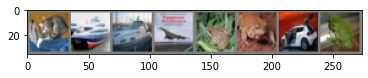

Answer:  cat ship ship plane
Predicted:  frog frog frog frog


In [22]:
data_iter = iter(testloader)
images, labels = data_iter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('Answer: ', ' '.join('%s' % classes[labels[j]] for j in range(4)))
net = Net()
# net.load_state_dict(torch.load())
outputs = net(images)
_, predicted = torch.max(outputs, 1)
 
print('Predicted: ', ' '.join('%s' % classes[predicted[j]] 
                              for j in range(4)))

In [23]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane :  0 %
Accuracy of   car :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog : 100 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %


In [24]:
# function to calculate accuracy
def print_accuracy(net, dataloader):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            # Inference on GPU
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    print('Accuracy of the network on the %d test images: %d %%' % (total,
        100 * correct / total))

In [26]:
# load trained model then test
#net.load_state_dict(torch.load(PATH))
#print_accuracy(net, testloader)